In [3]:
!pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-jlibe7tf
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/classification_models.git /tmp/pip-req-build-jlibe7tf
  Resolved https://github.com/qubvel/classification_models.git to commit a0f006e05485a34ccf871c421279864b0ccd220b
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 547.9 kB/s eta 0:00:00a 0:00:01
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-py3-none-any.whl size=20046 sha256=c330334113a2361fe47017973b166f1d5ec7a570485272af7f2d659813513bd2
  Stored in directory: /tmp/pip-ephem-wheel-cache-owt731oc/wheels/0b/96/56/27b17c903efc647c51e4f364bfc20aa67f8d3dccad63c4fb4e
Successfully built image-classifiers


In [4]:
!pip install -U albumentations

In [41]:
# Importing packages

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping 
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
import os
import pandas as pd
import zipfile
import cv2
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import gc
import random
import pydicom as dicom
from keras.applications.vgg16 import VGG16
from classification_models.tfkeras import Classifiers
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import albumentations as A

In [42]:
for dirname, _, filenames in os.walk('../input/acr-low-contrast'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../input/acr-low-contrast/Low_Contrast_.csv
../input/acr-low-contrast/Low_contranst/Low_contranst/0006.dcm
../input/acr-low-contrast/Low_contranst/Low_contranst/0014.dcm
../input/acr-low-contrast/Low_contranst/Low_contranst/0002.dcm
../input/acr-low-contrast/Low_contranst/Low_contranst/0001.dcm
../input/acr-low-contrast/Low_contranst/Low_contranst/0013.dcm
../input/acr-low-contrast/Low_contranst/Low_contranst/0008.dcm
../input/acr-low-contrast/Low_contranst/Low_contranst/0005.dcm
../input/acr-low-contrast/Low_contranst/Low_contranst/0016.dcm
../input/acr-low-contrast/Low_contranst/Low_contranst/0007.dcm
../input/acr-low-contrast/Low_contranst/Low_contranst/0011.dcm
../input/acr-low-contrast/Low_contranst/Low_contranst/0010.dcm
../input/acr-low-contrast/Low_contranst/Low_contranst/0004.dcm
../input/acr-low-contrast/Low_contranst/Low_contranst/0015.dcm
../input/acr-low-contrast/Low_contranst/Low_contranst/0012.dcm
../input/acr-low-contrast/Low_contranst/Low_contranst/0009.dcm
../input/ac

In [43]:
#Read csv

df = pd.read_csv('../input/acr-low-contrast/Low_Contrast_.csv', sep = ';', dtype = str, header=None)
df.rename(columns = {0 : 'Image', 1 : 'Groups'}, inplace = True)
df

,Image,Groups
0,0001,10
1,0002,10
2,0016,8
3,0014,9
4,0015,8
5,0013,9
6,0008,7
7,0006,7
8,0007,7
9,0004,9


In [207]:
#Read Images
SIZE = 256
data = []
for k in tqdm(range(0,len(df['Image']))):
    im = dicom.dcmread('../input/acr-low-contrast/Low_contranst/Low_contranst/'+str(df['Image'][k])+'.dcm')
    im = im.pixel_array
    im = cv2.resize(im, (256,256), interpolation = cv2.INTER_AREA)
    plt.imsave('ACR.png', im, cmap='gray')
    im = cv2.imread('./ACR.png',1)
    im = im[:,:,1]
    if k ==0:
        canny = cv2.Canny(im, 100, 150, 3)
        dilated = canny
        (cnt, heirarchy) = cv2.findContours(dilated.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        cnt = sorted(cnt, key=cv2.contourArea, reverse=True)
        x,y,w,h = cv2.boundingRect(cnt[0])
    ROI = im[y:y+h, x:x+w]
    #ROI = cv2.equalizeHist(ROI)
    data.append(ROI)

100%|██████████| 16/16 [00:00<00:00, 34.08it/s]


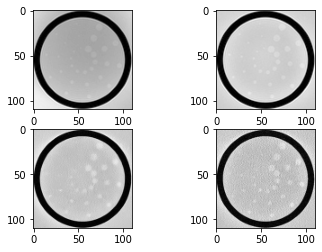

In [208]:
#Show images
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(data[0], cmap='gray')
axarr[0,1].imshow(data[1], cmap='gray')
axarr[1,0].imshow(data[2], cmap='gray')
axarr[1,1].imshow(data[3], cmap='gray')
plt.show()

In [209]:
data[3].shape[0]

110

In [210]:
#Reshape the data

data_reshaped = (np.asarray(data).reshape((len(data), data[0].shape[0], data[0].shape[1], 1))).astype('float16') / 255

enc = OneHotEncoder()
enc.fit(df[['Groups']])
label_one_hot = enc.transform(df[['Groups']]).toarray()

In [211]:
data_reshaped.shape

(16, 110, 110, 1)

In [212]:
X_train_validation, X_test, y_train_validation, y_test = train_test_split(data_reshaped, label_one_hot, test_size=0.3, random_state=0)

In [213]:
print(X_train_validation.shape)
print(X_test.shape)
print(y_train_validation.shape)
print(y_test.shape)

(11, 110, 110, 1)
(5, 110, 110, 1)
(11, 5)
(5, 5)


In [214]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range = 5,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.2,
    fill_mode = "constant"  
)

In [215]:
train_datagen.fit(X_train_validation)
data_generator = train_datagen.flow(X_train_validation, y_train_validation, batch_size=9)

In [216]:
SIZE = data[0].shape[0]

In [217]:
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
activation = 'sigmoid'

vgg16, _ = Classifiers.get('vgg16')
input_tensor = keras.layers.Input(shape=(SIZE, SIZE,1))
x = keras.layers.Conv2D(3,(1,1),padding='same')(input_tensor)
base_model = vgg16(input_shape = (SIZE, SIZE,3), include_top = False, weights = 'imagenet')(x)
y = keras.layers.GlobalAveragePooling2D()(base_model)
y2 = tf.keras.layers.BatchNormalization()(y)
y3 = tf.keras.layers.Flatten()(y2)
y4 = Dense(258, activation = activation, kernel_initializer = 'he_uniform')(y3)
prediction_layer = Dense(5, activation = 'softmax')(y4)
model = keras.models.Model(inputs=[input_tensor], outputs=[prediction_layer])
model.compile(optimizer='SGD',loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 110, 110, 1)]     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 110, 110, 3)       6         
_________________________________________________________________
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_7 ( (None, 512)               0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
flatten_7 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 258)               132

In [218]:
history = model.fit(data_generator, batch_size = 4, epochs = 100, validation_data = (X_test, y_test))

Epoch 1/100
2/2 [==============================] - 2s 279ms/step - loss: 1.7463 - accuracy: 0.2727 - val_loss: 1.8326 - val_accuracy: 0.0000e+00
Epoch 2/100
2/2 [==============================] - 0s 44ms/step - loss: 1.6562 - accuracy: 0.3636 - val_loss: 1.8228 - val_accuracy: 0.0000e+00
Epoch 3/100
2/2 [==============================] - 0s 61ms/step - loss: 1.6483 - accuracy: 0.2727 - val_loss: 2.0342 - val_accuracy: 0.0000e+00
Epoch 4/100
2/2 [==============================] - 0s 47ms/step - loss: 1.5769 - accuracy: 0.3636 - val_loss: 1.6249 - val_accuracy: 0.2000
Epoch 5/100
2/2 [==============================] - 0s 47ms/step - loss: 1.5303 - accuracy: 0.3636 - val_loss: 2.0800 - val_accuracy: 0.0000e+00
Epoch 6/100
2/2 [==============================] - 0s 63ms/step - loss: 1.5921 - accuracy: 0.3636 - val_loss: 2.1845 - val_accuracy: 0.0000e+00
Epoch 7/100
2/2 [==============================] - 0s 62ms/step - loss: 1.4534 - accuracy: 0.4545 - val_loss: 2.0709 - val_accuracy: 0.0000

In [219]:
inter_output_model = keras.Model(model.input, model.get_layer(index = 6).output )
inter_output = inter_output_model.predict(X_train_validation)
inter_output[0].shape

(258,)

In [220]:
#feature_extractor=model.predict(X_train_validation)
#X_for_RF = feature_extractor
X_for_RF_train = inter_output

In [221]:
RF_model = RandomForestClassifier(n_estimators = 100, random_state = 42)
RF_model.fit(X_for_RF_train, y_train_validation)

RandomForestClassifier(random_state=42)

In [222]:
inter_output_ = inter_output_model.predict(X_test)
inter_output_[0].shape
X_for_RF_test = inter_output_

In [223]:
#X_test_feature = model.predict(X_test)
#prediction_RF = RF_model.predict(X_test_feature)
prediction_RF = RF_model.predict(X_for_RF_test)
y_test_ = np.argmax(y_test, axis = 1)
prediction_RF_ = np.argmax(prediction_RF, axis = 1)

In [224]:
print(prediction_RF)
print(y_test)

[[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]]


In [225]:
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test_, prediction_RF_))

Accuracy =  0.2


<AxesSubplot:>

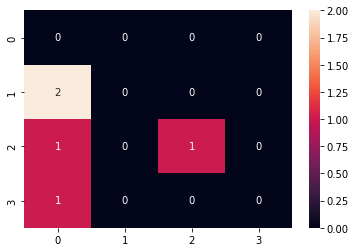

In [226]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_, prediction_RF_)
sns.heatmap(cm, annot=True)

In [46]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

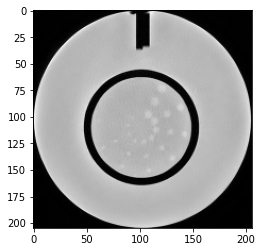

In [92]:
#plt.imshow(data[0], cmap='gray');
plt.imsave('imagem.png', data[2], cmap='gray')
im = cv2.imread('./imagem.png',1)
plt.imshow(im)
gray = im
im = im[:,:,1]
#im = cv2.equalizeHist(im)

Coins in the image:  7


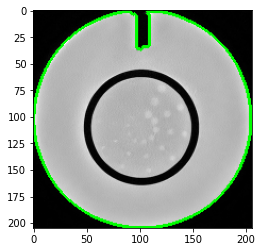

In [136]:
blur = cv2.GaussianBlur(gray, (11,11), 0)
blur = gray
canny = cv2.Canny(blur, 30, 150, 3)
dilated = canny
(cnt, heirarchy) = cv2.findContours(dilated.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
cnt = sorted(cnt, key=cv2.contourArea, reverse=True)
rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
cv2.drawContours(rgb, cnt[0], -1, (0,255,0), 2)

plt.imshow(rgb)



plt.show()

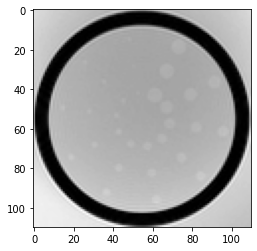

In [51]:
# Find bounding box and extract ROI
x,y,w,h = cv2.boundingRect(cnt[0])
ROI = im[y:y+h, x:x+w]

plt.imsave('ROI.png', ROI, cmap='gray')
im_roi = cv2.imread('./ROI.png',1)
plt.imshow(im_roi, cmap='gray');

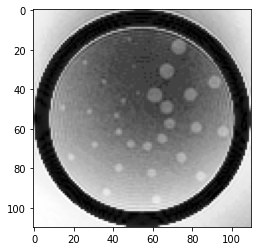

In [55]:
equ = cv2.equalizeHist(ROI)
plt.imshow(equ, cmap='gray');

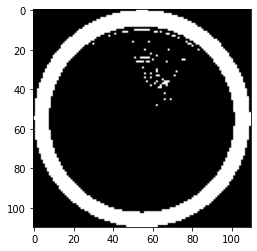

In [134]:
equ1 = equ#[:,:,1]
ret1, img_bi2 = cv2.threshold(equ1, 50,150,cv2.THRESH_BINARY_INV)
plt.imshow(img_bi2, cmap='gray');

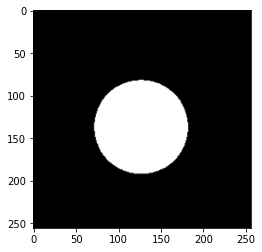

In [608]:
epsilon0 = 0.001*cv2.arcLength(cnt[0],True)
approx0 = cv2.approxPolyDP(cnt[0],epsilon0,True)
canvas = np.zeros(gray.shape, np.uint8)
cv2.drawContours(canvas, [approx0],-1, (255, 255,255), thickness = -1, lineType = cv2.LINE_AA)
canvas = canvas[:,:,1]
plt.imshow(canvas,cmap="gray")
plt.show()

In [609]:
new_im = im

In [610]:
for i in range(0,canvas.shape[0]):
    for j in range(0,canvas.shape[1]):
        if canvas[i,j] == 255:
            canvas[i,j] = new_im[i,j]

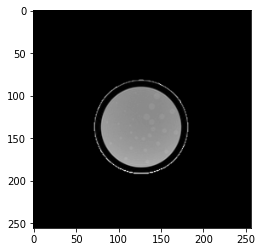

In [611]:
plt.imshow(canvas,cmap="gray")
plt.show()

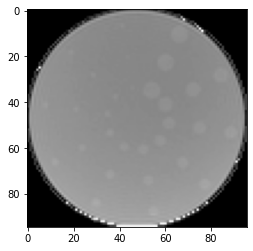

In [598]:
ROI = canvas[y:y+h, x:x+w]

plt.imsave('ROI_canvas.png', ROI, cmap='gray')
im_roi = cv2.imread('./ROI_canvas.png',1)
plt.imshow(im_roi, cmap='gray');

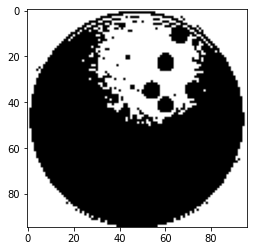

In [604]:
im_bi1 = im_roi[:,:,1]
ret1, img_bi2 = cv2.threshold(im_bi, 137,143,cv2.THRESH_BINARY_INV)
plt.imshow(img_bi2, cmap='gray');

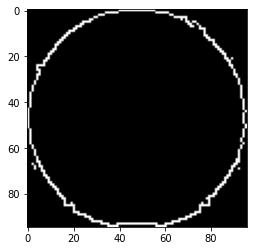

In [501]:
canny = cv2.Canny(im_roi,130,145)
plt.imshow(canny,cmap="gray")
plt.show()

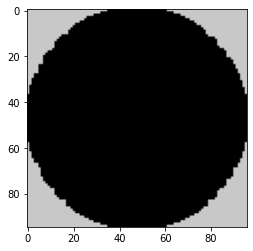

In [499]:
kernel = np.ones((5,5),np.uint8)
grey = cv2.threshold(im_roi,12,200,cv2.THRESH_BINARY_INV)[1]
grey = cv2.morphologyEx(grey, cv2.MORPH_CLOSE, kernel)
plt.imshow(grey,cmap="gray")
plt.show()

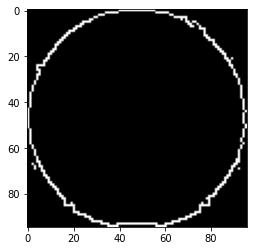

In [500]:
ROI_canny = cv2.Canny(im_roi, 0, 120, 3)
plt.imshow(ROI_canny, cmap='gray')

In [469]:
im_roi = im_roi[:,:,1]
circles = cv2.HoughCircles(im, cv2.HOUGH_GRADIENT, 10, 100)
circles

array([[[125., 135.,  52.],
        [215.,  15.,  98.],
        [165., 255.,  75.]]], dtype=float32)

In [470]:
output = im.copy()

In [471]:
circles

array([[[125., 135.,  52.],
        [215.,  15.,  98.],
        [165., 255.,  75.]]], dtype=float32)

In [472]:
if circles is not None:
# convert the (x, y) coordinates and radius of the circles to integers
    circles = np.round(circles[0, :]).astype("int")
# loop over the (x, y) coordinates and radius of the circles
    for (x, y, r) in circles:
        # draw the circle in the output image, then draw a rectangle
        # corresponding to the center of the circle
        cv2.circle(output, (x, y), r, (0, 255, 0), 4)
        cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
# show the output image
cv2.imshow("output", np.hstack([image, output]))
cv2.waitKey(0)

error: OpenCV(4.5.4) /tmp/pip-req-build-jpmv6t9_/opencv/modules/highgui/src/window.cpp:1274: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


In [ ]:
mask = np.zeros(img.shape, np.uint8)
cv.drawContours(mask, contours, -1, (0,255,0),1)

In [ ]:
# Find bounding box and extract ROI
x,y,w,h = cv2.boundingRect(cnt[0])
ROI = im[y:y+h, x:x+w]

plt.imsave('ROI.png', ROI, cmap='gray')
im_roi = cv2.imread('./ROI.png',1)
plt.imshow(im_roi, cmap='gray');

In [ ]:
im_ = im_roi[:,:,1]
_,im_b = cv2.threshold(im_,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#im_b = cv2.bitwise_not(im_b)
plt.imshow(im_b, cmap='gray');

In [ ]:
ROI_canny = cv2.Canny(im_roi, 0, 120, 3)
plt.imshow(canny, cmap='gray')

In [ ]:
#blur = cv2.GaussianBlur(gray, (11,11), 0)
blur = im_roi
canny = cv2.Canny(blur, 30, 150, 3)
dilated = canny
#dilated = cv2.dilate(canny, (1,1), iterations = 2)

(cnt, heirarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cnt = sorted(cnt, key=cv2.contourArea, reverse=True)
rgb = cv2.cvtColor(ROI, cv2.COLOR_BGR2RGB)
cv2.drawContours(rgb, cnt[0], -1, (0,255,0), 2)

plt.imshow(rgb)


print('Coins in the image: ', len(cnt))
plt.show()

In [ ]:
blur = im_roi
canny = cv2.Canny(blur, 100, 120, 3)
plt.imshow(canny)

In [ ]:
blur = im_roi
canny = cv2.Canny(blur, 30, 150, 3)
plt.imshow(canny)

In [ ]:
ROI

In [ ]:
canny = cv2.Canny(blur, 30, 150, 3)
dilated = cv2.dilate(canny, (2,2), iterations = 3)
(cnt, heirarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2.drawContours(rgb, cnt[0], -1, (0,255,0), 2)
#cv2.drawContours(rgb, cnt[0], 3, (0,255,0), 3)

plt.imshow(rgb)


print('Coins in the image: ', len(cnt))
plt.show()

In [ ]:

blur = cv2.GaussianBlur(gray, (15,15), 0)
plt.imshow(blur, cmap='gray')

canny = cv2.Canny(blur, 30, 150, 3)
plt.imshow(canny, cmap='gray')

dilated = cv2.dilate(canny, (2,2), iterations = 3)
plt.imshow(dilated, cmap='gray')

(cnt, heirarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#cnt = sorted(cnts, key=cv2.contourArea, reverse=True)
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2.drawContours(rgb, cnt[0], -1, (0,255,0), 2)

plt.imshow(rgb)


print('Coins in the image: ', len(cnt))
plt.show()

In [ ]:
# Find bounding box and extract ROI
x,y,w,h = cv2.boundingRect(cnt)
ROI = gray[y:y+h, x:x+w]

cv2.imshow('ROI',ROI)
plt.imsave('ROI.png', ROI, cmap='gray')
cv2.waitKey()

In [ ]:
blur = cv2.GaussianBlur(im, (3,), 0)
plt.imshow(blur, cmap='gray')

In [ ]:
canny = cv2.Canny(blur, 0, 120, 3)
plt.imshow(canny, cmap='gray')

In [ ]:
dilated = cv2.dilate(canny, (1,1), iterations = 2)
plt.imshow(dilated, cmap='gray')

In [ ]:
(cnt, heirarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
cv2.drawContours(rgb, cnt, -1, (0,255,0), 2)

plt.imshow(rgb)


print('Coins in the image: ', len(cnt))
plt.show()

In [ ]:
_,binary = cv2.threshold(blur,0,80,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
binary = cv2.bitwise_not(binary)
plt.imshow(binary, cmap='gray')

In [ ]:
# Find contour and sort by contour area
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

# Find bounding box and extract ROI
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    ROI = image[y:y+h, x:x+w]
    break

cv2.imshow('ROI',ROI)
cv2.imwrite('ROI.png',ROI)
cv2.waitKey()